<a href="https://colab.research.google.com/github/nattntn/Multi-task_Paper/blob/main/Multi(Gender)_Eff_250_Unfreeze_Predict_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##เรียกใช้ CSV

In [ ]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import

In [ ]:
import os
import numpy as np
import pandas as pd
#import efficientnet.tfkeras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Clone Efficient

In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


# Load Model

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Multi_task(Gender)(7-25)/08_Multi_2e-4_250_Unfreeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})


In [ ]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Multi_task(Gender)(7-25)/08_Multi_2e-4_250_Unfreeze.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normalization[0][0

In [ ]:
height = width = model.input_shape[1]
print(f"height: {height}, width: {width}")

height: 224, width: 224


# Data Preparation

In [ ]:
train = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/table_cut_images/table_train_10Fold_forGender.csv')
train

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...,...
4184,4184,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J375.jpg,3,1
4185,4185,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J437.jpg,5,1
4186,4186,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J480.jpg,5,1
4187,4187,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J491.jpg,6,1


In [ ]:
train = train.iloc[:,1:]

In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'Normal')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'Test')
print(test_dir)

/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal
/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Test


In [ ]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = ['Gender_Class','Age(year)'],
        class_mode = 'multi_output',
        color_mode= 'rgb',
        target_size=(height, width),# รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        batch_size=batch_size)
#label
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#print(labels)

Found 4189 validated image filenames.


In [ ]:
test = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/table_cut_images/table_test_forGender.csv')
test

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...,...
938,938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female
939,939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female
940,940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female
941,941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female


In [ ]:
test = test.iloc[:,1:]
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...
938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female
939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female
940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female
941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female


# Predict

In [ ]:
len(model.output)

2

In [ ]:
model.output_names

['prediction_layer', 'prediction_layer2']

In [ ]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path,model, height, width):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result

In [ ]:
# Predict for each image in the test dataset
pred_list_regression = []  # Store regression results
pred_list_classification = []  # Store binary classification results

img_path = test['Path_Name'].tolist()

for i in range(len(img_path)):
    predictions = predict_image(img_path[i], model, height, width)

    # Access the regression result (output 0)
    regression_result = predictions[1]

    # Access the classification result (output 1)
    classification_result = predictions[0] # Use a threshold to determine the class

    pred_list_regression.append(regression_result)
    pred_list_classification.append(classification_result)


1/1 [==============================] - 0s 28ms/step


In [ ]:
predictions

[array([[4.028909e-11]], dtype=float32), array([[18.435654]], dtype=float32)]

# Age Estination

In [ ]:
list_Regression_predict = []
for i in pred_list_regression:
  i = i[0][0]
  list_Regression_predict.append(i)

In [ ]:
list_Regression_predict

[7.959019,
 7.953671,
 8.1700535,
 8.00595,
 7.9752383,
 7.980172,
 7.9352484,
 7.9417973,
 8.018171,
 7.966926,
 7.9420605,
 7.949745,
 7.9771013,
 7.974953,
 7.9787397,
 7.9543877,
 7.350691,
 7.9786024,
 7.9439673,
 7.953427,
 8.151017,
 7.967395,
 8.52609,
 8.000036,
 7.970214,
 7.9437437,
 7.775797,
 7.9539933,
 7.9666452,
 8.402037,
 7.8446016,
 7.954421,
 7.9671364,
 7.943018,
 7.9488015,
 7.986885,
 7.892067,
 7.983327,
 8.002745,
 7.942521,
 7.9381914,
 7.984629,
 7.980838,
 8.121826,
 8.008636,
 7.969551,
 7.951708,
 7.9536633,
 7.939803,
 8.53379,
 8.837945,
 8.849711,
 8.832421,
 8.943605,
 8.882517,
 8.891404,
 8.877927,
 8.810221,
 8.866184,
 8.863757,
 8.863978,
 8.791738,
 8.861736,
 9.69102,
 9.6293335,
 8.829572,
 8.859207,
 9.689253,
 9.616382,
 8.7982645,
 8.690917,
 9.677949,
 9.406186,
 8.770942,
 8.465791,
 9.698652,
 9.693315,
 8.873134,
 8.854827,
 9.698652,
 9.693315,
 8.344512,
 8.867437,
 8.858334,
 8.866799,
 8.884371,
 8.889746,
 8.853332,
 8.798279,
 9.60

In [ ]:
print(type(list_Regression_predict))

<class 'list'>


In [ ]:
age_predict = np.around(list_Regression_predict) # array
age_predict

array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  7.,  8.,  8.,  8.,  8.,  8.,  9.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10.,
        9.,  9., 10., 10.,  9.,  9., 10.,  9.,  9.,  8., 10., 10.,  9.,
        9., 10., 10.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10.,  9.,
        9.,  9.,  8., 11., 11., 10., 10., 11., 11.,  9., 10.,  9.,  9.,
       10., 10., 10., 10., 10., 11.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9.,  9., 10., 10.,  9.,  9.,  9., 10., 10.,  9.,  9.,
        9.,  9.,  9.,  9.,  9., 10.,  9., 10., 10., 10., 10., 11., 11.,
        9., 10., 10., 10., 11., 11., 10., 10., 10., 10.,  9.,  9., 10.,
       10.,  9.,  9., 11., 10., 11., 11., 11., 10., 10., 11., 11.,  9.,
        9.,  9., 10.,  9.,  9., 11., 11.,  9.,  9.,  9.,  9., 10

In [ ]:
act_age = test['Age(year)'].to_numpy() #ค่าจริง array
act_age

array([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

## confusion_matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_age, age_predict)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_age, age_predict))#performance

classifier accuracy = 21.10286320254507%
              precision    recall  f1-score   support

           7       1.00      0.02      0.04        50
           8       0.06      0.06      0.06        48
           9       0.32      0.52      0.39        50
          10       0.34      0.39      0.36        49
          11       0.42      0.46      0.44        50
          12       0.42      0.46      0.44        48
          13       0.39      0.34      0.36        50
          14       0.31      0.51      0.38        47
          15       0.24      0.24      0.24        51
          16       0.14      0.30      0.19        50
          17       0.16      0.35      0.22        51
          18       0.03      0.04      0.04        50
          19       0.04      0.02      0.03        49
          20       0.00      0.00      0.00        49
          21       0.09      0.08      0.09        50
          22       0.16      0.14      0.15        50
          23       0.11      0.08      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 76.24999999999999, 'Predicted label')

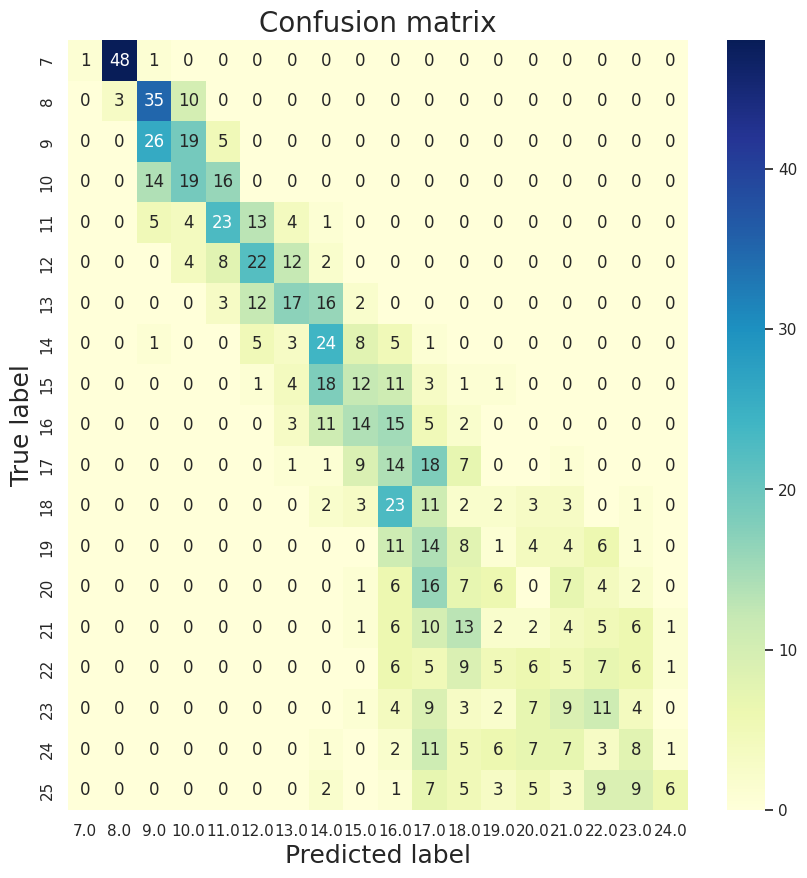

In [ ]:
#create CF
data = {'Actual': act_age,'Predicted' : age_predict}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_age, age_predict)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_age,age_predict)
mse = mean_squared_error(act_age,age_predict)
rmse = mean_squared_error(act_age,age_predict,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 1.7815482502651114
MSE: 6.506892895015906
RMSE: 2.5508612065370992


# Gender Prediction

In [ ]:
list_Classification_predict = []
for i in pred_list_classification:
  i = i[0][0]
  list_Classification_predict.append(i)

In [ ]:
list_Classification_predict

[0.0048616743,
 0.00023961056,
 0.12680337,
 0.0063724713,
 0.7634994,
 0.00021917564,
 8.321444e-07,
 2.6414646e-06,
 0.27425486,
 0.9965623,
 0.3027171,
 0.00069466484,
 4.4404336e-05,
 6.5453164e-06,
 0.010677224,
 0.00030346515,
 0.005246802,
 0.03866147,
 0.03477039,
 0.015040008,
 0.99799585,
 0.982927,
 0.9477145,
 0.99271387,
 0.21819401,
 0.99999666,
 0.99866486,
 0.9999162,
 0.9999225,
 0.99967813,
 0.99844736,
 0.99999964,
 0.99997437,
 0.9887449,
 0.98676664,
 0.021059565,
 0.997759,
 0.99932826,
 0.9649311,
 0.0005884394,
 0.20187773,
 0.42258185,
 0.9485872,
 0.9999361,
 0.9999908,
 0.9999994,
 0.9999987,
 0.06909845,
 0.00044614688,
 4.4154905e-05,
 0.00030187485,
 0.3404907,
 0.60832757,
 0.0012102051,
 4.379794e-05,
 0.22879711,
 0.44184652,
 0.28188282,
 0.9980603,
 0.9706287,
 0.8891206,
 0.00058581965,
 8.670406e-06,
 5.8123703e-07,
 9.932678e-06,
 0.996664,
 0.0046146945,
 0.00012352738,
 7.787951e-05,
 0.78768945,
 0.9992926,
 0.001188734,
 0.0032123148,
 0.006000

In [ ]:
print(type(list_Classification_predict))

<class 'list'>


In [ ]:
gender_predict_str = []
# ใช้ลูป for เพื่อแปลงค่าและเพิ่มเข้าใน NumPy array
for value in list_Classification_predict:
    if value >= 0.5:
        gender_predict_str = np.append(gender_predict_str, 'Male')
    else:
        gender_predict_str = np.append(gender_predict_str, 'Female')

# แสดงผลลัพธ์
print(gender_predict_str)

['Female' 'Female' 'Female' 'Female' 'Male' 'Female' 'Female' 'Female'
 'Female' 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female'
 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male'
 'Female' 'Male' 'Male' 'Male' 'Female' 'Female' 'Female' 'Male' 'Male'
 'Male' 'Male' 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Male' 'Male' 'Male'
 'Female' 'Female' 'Female' 'Female' 'Male' 'Female' 'Female' 'Female'
 'Male' 'Male' 'Female' 'Female' 'Female' 'Female' 'Male' 'Male' 'Male'
 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Male' 'Female' 'Female'
 'Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female' 'Male' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Male' 'Male' 'Female' 'Female' 'Male' 'Male'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Male' 'Male' 'Male

In [ ]:
gender_predict_int = []
# ใช้ลูป for เพื่อแปลงค่าและเพิ่มเข้าใน NumPy array
for value in list_Classification_predict:
    if value >= 0.5:
        gender_predict_int = np.append(gender_predict_int, 1)
    else:
        gender_predict_int = np.append(gender_predict_int, 0)

# แสดงผลลัพธ์
print(gender_predict_int)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.

In [ ]:
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...
938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female
939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female
940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female
941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female


In [ ]:
gender_predict_str # array str
act_gender_str = np.array(test['Gender_Predict'].tolist())

gender_predict_int # array int
act_gender_int = np.array(test['Gender_Class'].tolist()) #ค่าจริง

## confusion_matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_gender_str, gender_predict_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_gender_str, gender_predict_str))#performance

classifier accuracy = 82.92682926829268%
              precision    recall  f1-score   support

      Female       0.83      0.83      0.83       475
        Male       0.83      0.83      0.83       468

    accuracy                           0.83       943
   macro avg       0.83      0.83      0.83       943
weighted avg       0.83      0.83      0.83       943



Text(0.5, 76.24999999999999, 'Predicted label')

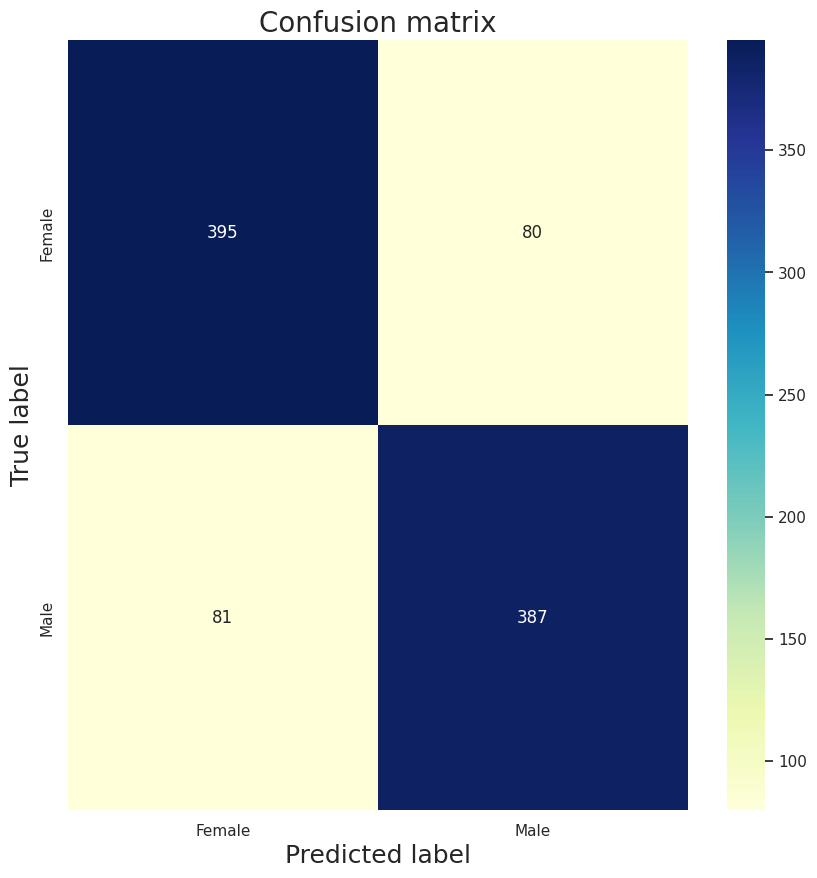

In [ ]:
#create CF
data = {'Actual': act_gender_str,'Predicted' : gender_predict_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_gender_str, gender_predict_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_gender_int,gender_predict_int)
mse = mean_squared_error(act_gender_int,gender_predict_int)
rmse = mean_squared_error(act_gender_int,gender_predict_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.17073170731707318
MSE: 0.17073170731707318
RMSE: 0.4131969352706687


# ตารางรวม

In [ ]:
#Regression
test['Age_predict'] = list_Regression_predict # ผลที่ทำนาย
test['Age_predict_int'] = age_predict

In [ ]:
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Age_predict,Age_predict_int
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,7.959019,8.0
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,7.953671,8.0
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,8.170053,8.0
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,8.005950,8.0
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,7.975238,8.0
...,...,...,...,...,...,...,...,...,...,...
938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female,22.577393,23.0
939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female,18.165268,18.0
940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female,21.707977,22.0
941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female,22.071957,22.0


In [ ]:
test['Gender_predict'] = list_Classification_predict # ผลที่ทำนาย
test['Gender_predict_str'] = gender_predict_str
test['Gender_predict_int'] = gender_predict_int

In [ ]:
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Age_predict,Age_predict_int,Gender_predict,Gender_predict_str,Gender_predict_int
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,7.959019,8.0,4.861674e-03,Female,0.0
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,7.953671,8.0,2.396106e-04,Female,0.0
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,8.170053,8.0,1.268034e-01,Female,0.0
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,8.005950,8.0,6.372471e-03,Female,0.0
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,7.975238,8.0,7.634994e-01,Male,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J132.jpg,0,Female,22.577393,23.0,2.302212e-04,Female,0.0
939,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J145.jpg,0,Female,18.165268,18.0,2.067878e-02,Female,0.0
940,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J149.jpg,0,Female,21.707977,22.0,1.005911e-02,Female,0.0
941,25,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J158.jpg,0,Female,22.071957,22.0,3.453355e-10,Female,0.0
